In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [29]:
import re
import json 
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
from transformers import get_scheduler
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
num_epochs = 101
# num_epochs = 10
batch_size = 32
hidden_dim = 256
max_length = 256

In [30]:
print(device)

cuda


In [31]:
class MedicalTCDataset(Dataset):
    def __init__(self, data):
        self.data = data['medical_abstract']
        self.labels = data['condition_label']
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [32]:
def clean_medical_text(text):
    text = text.lower()
    text = re.sub('[' + string.punctuation + ']', '', text)
    text = re.sub(r'\s+', ' ', text)
    stopwords = ['the', 'a', 'an', 'in', 'on', 'is', 'are', 'was', 'were', 'to', 'for', 'of']
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text

In [33]:
# train = pd.read_csv("/private/CSE 256/data/medical_tc_train.csv")
# test =  pd.read_csv("/private/CSE 256/data/medical_tc_test.csv")
labels = pd.read_csv("./data/medical_tc_labels.csv")
mappings = {
    0: "non-cardiovascular",
    1: "cardiovascular"
}
inverse_mapping = {
    "non-cardiovascular" : 0,
    "cardiovascular" : 1
}

In [34]:
# train['medical_abstract'] = train['medical_abstract'].apply(clean_medical_text)
# test['medical_abstract'] = test['medical_abstract'].apply(clean_medical_text)
# train['condition_label'] = train['condition_label'].apply(lambda x: 0 if x in [1,2,3,5] else 1)
# test['condition_label'] = test['condition_label'].apply(lambda x: 0 if x in [1,2,3,5] else 1)
# train['condition_label'] = train['condition_label'].apply(lambda x: mappings[x])
# test['condition_label'] = test['condition_label'].apply(lambda x: mappings[x])

In [35]:
# train.to_csv("/content/gdrive/MyDrive/XAI/data/medical_tc_train_cleaned.csv", index=False)
# test.to_csv("/content/gdrive/MyDrive/XAI/data/medical_tc_test_cleaned.csv", index=False)

### Fine Tuning

In [36]:
train = pd.read_csv("./data/medical_tc_train_cleaned.csv")
test = pd.read_csv("./data/medical_tc_test_cleaned.csv")

In [37]:
train_dataset = MedicalTCDataset(train)
test_dataset = MedicalTCDataset(test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [38]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model.classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size, hidden_dim),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden_dim, num_classes)
)
model.to(device)
print()

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [39]:
model.load_state_dict(torch.load("./models/biobert_fine_tuned_epoch_90.pt")['model_state_dict'])
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [40]:
model.train()
for i, param in enumerate(model.bert.parameters()):
    if i < 185:
      param.requires_grad = False
    else:
      param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
  
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [41]:
criterion = torch.nn.CrossEntropyLoss()
train_loss = []
model.to(device)
model.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in tqdm(range(91, num_epochs)):
    for text, labels in train_dataloader:
        optimizer.zero_grad()
        tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=max_length, truncation=True) for v in text]).cuda()
        a_mask = (tv!=0).type(torch.int64).cuda()
        outputs = model(tv,attention_mask=a_mask)[0].cuda()
        labesl = list(labels)
        labels = [inverse_mapping[l] for l in labels]
        labels = torch.Tensor(labels).long().cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': loss.item(),
        }, './models/biobert_fine_tuned_epoch_{}.pt'.format(epoch))
        np.save("./results/biobert_fine_tuned_loss_epoch_{}.npy".format(epoch), np.array(train_loss))

  0%|          | 0/36461 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def test_model():
    predictions = []
    trueLabels = []

    with torch.no_grad():
        for text, labels in tqdm(test_dataloader):
            tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=max_length, truncation=True) for v in text]).cuda()
            a_mask = (tv!=0).type(torch.int64).cuda()
            outputs = model(tv,attention_mask=a_mask)[0].cpu()
            outputs = nn.functional.softmax(outputs, dim=1).numpy()
            labels = [inverse_mapping[l] for l in labels]
            predictions.extend(outputs)
            trueLabels.extend(labels)
    predictions = np.argmax(predictions,axis=1)
    return accuracy_score(predictions, trueLabels), f1_score(predictions, trueLabels)

In [43]:
import matplotlib.pyplot as plt
epochNumbers = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracies, f1s = [], []
for epochNumber in epochNumbers:
    model.load_state_dict(torch.load("./models/biobert_fine_tuned_epoch_{}.pt".format(epochNumber))['model_state_dict'])
    model.to(device)
    accuracy, f1 = test_model()
    accuracies.append(accuracy)
    f1s.append(f1)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [44]:
print(accuracies)

[0.8635734072022161, 0.868421052631579, 0.8601108033240997, 0.8497229916897507, 0.8490304709141274, 0.8421052631578947, 0.8448753462603878, 0.8331024930747922, 0.83898891966759, 0.8414127423822715]


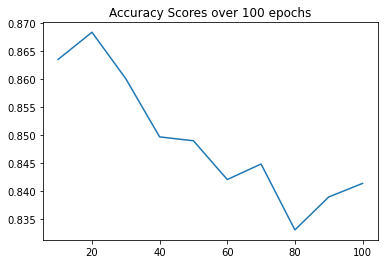

In [47]:
plt.plot(epochNumbers, accuracies)
plt.title("Accuracy Scores over 100 epochs")
plt.show()

In [45]:
plt.plot(epochNumbers, accuracies)
print(f1s)
plt.show()

[0.702416918429003, 0.6695652173913044, 0.6699346405228758, 0.6555555555555556, 0.6651305683563747, 0.6529680365296803, 0.6254180602006689, 0.6106623586429726, 0.6222583265637693, 0.6051724137931034]


In [ ]:
plt.title("F1 Scores over 100 epochs")

In [ ]:
model.load_state_dict(torch.load("./models/biobert_fine_tuned_epoch_4.pt")['model_state_dict'])
model.to(device)
test_model()

In [ ]:
model.load_state_dict(torch.load("./models/biobert_fine_tuned_epoch_6.pt")['model_state_dict'])
model.to(device)
test_model()

In [ ]:
model.load_state_dict(torch.load("./models/biobert_fine_tuned_epoch_8.pt")['model_state_dict'])
model.to(device)
test_model()

In [ ]:
text = ["supravalvar aortic stenosis complication aortic valve surgery after patient had aortic valvotomy and aortotomy relief valvar aortic stenosis supravalvar stenosis developed over next six years"]
labels = ['cardiovascular']
with torch.no_grad():
    optimizer.zero_grad()
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=max_length, truncation=True) for v in text]).cuda()
    a_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=a_mask)[0].cpu()
#     labesl = list(labels)
    labels = [inverse_mapping[l] for l in labels]
    labels = torch.Tensor(labels).long()
    loss = criterion(outputs, labels)
#     eval_loss.append(loss.item())
    progress_bar.update(1)

In [ ]:
print(outputs)

In [ ]:
text = ["severe thrombocytopenia after paracetamol overdose two patients with severe thrombocytopenia after paracetamol overdose described platelet count lowest two days after overdose neither leucopenia nor anaemia occurred"]
labels = ['non-cardiovascular']
with torch.no_grad():
    optimizer.zero_grad()
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=max_length, truncation=True) for v in text]).cuda()
    a_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=a_mask)[0].cpu()
    labesl = list(labels)
    labels = [inverse_mapping[l] for l in labels]
    labels = torch.Tensor(labels).long()
    loss = criterion(outputs, labels)
    eval_loss.append(loss.item())
    progress_bar.update(1)

In [ ]:
print(outputs)

In [ ]:
print(labels)

In [ ]:
print(loss)